<a href="https://colab.research.google.com/github/thaCripple/simple-ANNs-pytorch/blob/prediction_collection_improvement/Simple_Image_Classification/Simple_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First Image Classification in PyTroch



# Imports and installs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision.transforms import v2

In [ ]:
!pip install -q torchmetrics

In [ ]:
import torchmetrics

In [ ]:
from pathlib import Path

# Get the data

In [ ]:
Path.cwd()

PosixPath('/content')

In [ ]:
download_dir = Path(Path.cwd(), "fashion_data")
download_dir

PosixPath('/content/fashion_data')

ToImage() returns ints, models usually need float32, so we need to change the dtype


[https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_e2e.html#transforms](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_e2e.html#transforms)

In [ ]:
transforms = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

In [ ]:
train_ds = torchvision.datasets.FashionMNIST(root=download_dir, train=True, download=True, transform=transforms)
test_ds = torchvision.datasets.FashionMNIST(root=download_dir, train=False, download=True, transform=transforms)

In [ ]:
train_ds.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
img, label = train_ds[0]

In [ ]:
type(img)

torchvision.tv_tensors._image.Image

In [ ]:
img.shape # Channels, Height, Width

torch.Size([1, 28, 28])

# Visualize random images

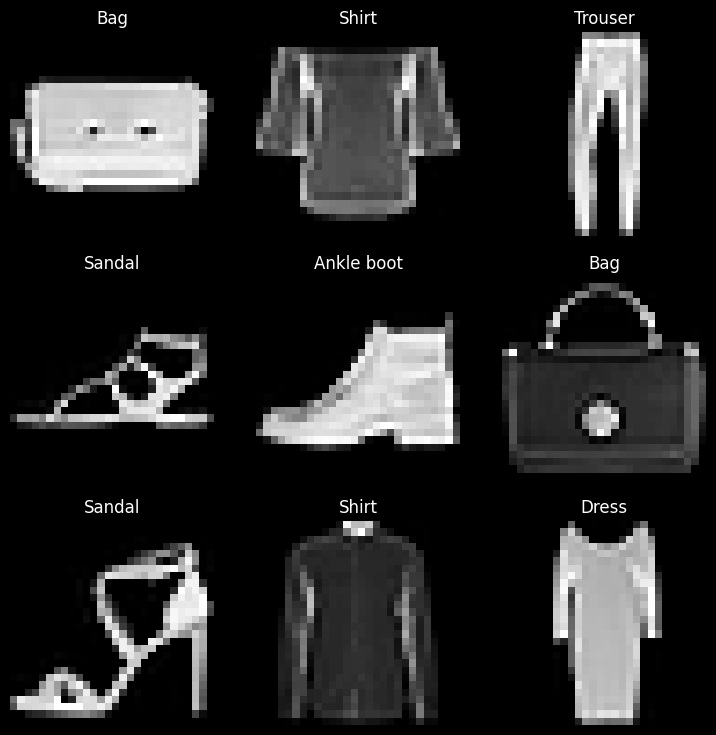

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
fig.set_facecolor(color="black")

# Generate random integers to index the train dataset and get some images
img_idxs = torch.randint(0, len(train_ds), (3*3,)) # low, high, size
for i in range(3*3):
  img_idx = img_idxs[i]
  # Images are in (Channel, Height, Width) format. We move the channels to be the last dimension
  # input: input tensor, source: dimension to move, destination: where to move the dimension
  img = torch.movedim(input=train_ds[img_idx][0], source=0, destination=2)

  # Extract the label from the dataset.classes list
  label_idx = train_ds[img_idx][1]
  img_label = train_ds.classes[label_idx]

  # axes is a 2D array, so we need to flatten it before indexing
  ax = axes.flatten()[i]
  ax.imshow(img, cmap="gray")
  ax.axis("off")
  ax.set_title(label=img_label, color="white")

# Create dataloaders

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
len(test_dl)

313

In [ ]:
for imgs, lbls in train_dl:
  print(f"{type(imgs)}, {imgs.shape}")
  print(f"{type(lbls)}, {lbls.shape}")
  print(imgs[0].dtype)
  break

<class 'torch.Tensor'>, torch.Size([32, 1, 28, 28])
<class 'torch.Tensor'>, torch.Size([32])
torch.float32


# Build a baseline Model

In [ ]:
class BaselineModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.sequence = nn.Sequential(
        nn.Flatten(), # nn.Linear in_features has to be an int, so we can't pass a 3D array as input shape; we have to use nn.Flatten
        nn.Linear(in_features=(1*28*28), out_features=10),
        nn.Linear(in_features=10, out_features=10),
    )

  def forward(self, x):
    return self.sequence(x)

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

In [ ]:
model0 = torch.compile(BaselineModel()).to(device=device)

In [ ]:
# del model0

model doesn't have a `.device` attribute but its parameters tensor does

We can get the parameters generator and use `next()` to get the 1st tensor and check its `.device` attribute

In [ ]:
next(model0.parameters()).device

device(type='cuda', index=0)

In [ ]:
model0_loss_fn = nn.CrossEntropyLoss()
model0_optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.01)

# Define the training and testing loops

In [ ]:
# @torch.compile ======== throws errors during training
def train_step(model, train_dl, loss_fn, optimizer) -> tuple:

  total_epoch_loss = 0
  total_epoch_accuracy = 0
  num_batches = len(train_dl)

  model.train()
  for x_batch, y_batch in train_dl:
    x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)

    y_logits = model(x_batch)
    loss = loss_fn(y_logits, y_batch)
    total_epoch_loss += loss.item() # avoid accumulating gradients, we only need the loss value

    accuracy = torchmetrics.functional.classification.multiclass_accuracy(preds=y_logits, target=y_batch, num_classes=10)
    total_epoch_accuracy += accuracy.item() # avoid accumulating gradients, we only need the accuracy value

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_accuracy = total_epoch_accuracy / num_batches
  return mean_epoch_loss, mean_epoch_accuracy

In [ ]:
# @torch.compile ======== throws errors during training
def test_step(model, test_dl, loss_fn) -> tuple:

  total_epoch_loss = 0
  total_epoch_accuracy = 0
  num_batches = len(test_dl)

  model.eval()
  with torch.inference_mode():
    for x_batch, y_batch in test_dl:
      x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)

      y_logits = model(x_batch)
      loss = loss_fn(y_logits, y_batch)
      total_epoch_loss += loss.item()

      accuracy = torchmetrics.functional.classification.multiclass_accuracy(preds=y_logits, target=y_batch, num_classes=10)
      total_epoch_accuracy += accuracy.item()

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_accuracy = total_epoch_accuracy / num_batches
  return mean_epoch_loss, mean_epoch_accuracy

# Train the Baseline Model

In [ ]:
# EPOCHS = 3

In [ ]:
# train_metrics = []
# test_metrics = []

# for epoch in range(EPOCHS):
#   print(f"Epoch {epoch}/{EPOCHS-1}")
#   train_metrics.append(train_step(model=model0, train_dl=train_dl, loss_fn=model0_loss_fn, optimizer=model0_optimizer))
#   test_metrics.append(test_step(model=model0, test_dl=test_dl, loss_fn=model0_loss_fn))
#   print(f"Train loss: {train_metrics[-1][0]:.3f} | Train accuracy: {train_metrics[-1][1]:.2f}")
#   print(f"Test loss: {test_metrics[-1][0]:.3f} | Test accuracy: {train_metrics[-1][1]:.2f}")

# Build Model1 with non-linear layers

In [ ]:
class ModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.sequence = nn.Sequential(
        nn.Flatten(), # nn.Linear in_features has to be an int, so we can't pass a 3D array as input shape; we have to use nn.Flatten
        nn.Linear(in_features=(1*28*28), out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=10)
    )

  def forward(self, x):
    return self.sequence(x)

In [ ]:
try:
  del model1
except Exception as e:
  print(e)

In [ ]:
model1 = torch.compile(ModelV1()).to(device=device)

In [ ]:
model1_loss_fn = nn.CrossEntropyLoss()
model1_optimizer = torch.optim.Adam(params=model1.parameters(), lr=0.01)

# Train Model1

In [ ]:
next(model1.parameters()).device

device(type='cuda', index=0)

In [ ]:
EPOCHS = 3

In [ ]:
train_metrics = []
test_metrics = []

for epoch in range(EPOCHS):
  print(f"Epoch {epoch}/{EPOCHS-1}")
  train_metrics.append(train_step(model=model1, train_dl=train_dl, loss_fn=model1_loss_fn, optimizer=model1_optimizer))
  test_metrics.append(test_step(model=model1, test_dl=test_dl, loss_fn=model1_loss_fn))
  print(f"Train loss: {train_metrics[-1][0]:.3f} | Train accuracy: {train_metrics[-1][1]:.2f}")
  print(f"Test loss: {test_metrics[-1][0]:.3f} | Test accuracy: {train_metrics[-1][1]:.2f}")

Epoch 0/2
Train loss: 0.561 | Train accuracy: 0.79
Test loss: 0.507 | Test accuracy: 0.79
Epoch 1/2
Train loss: 0.478 | Train accuracy: 0.82
Test loss: 0.509 | Test accuracy: 0.82
Epoch 2/2
Train loss: 0.464 | Train accuracy: 0.83
Test loss: 0.514 | Test accuracy: 0.83


# Build Model 2 with non-linear layers and drop-out

In [ ]:
class ModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.sequence = nn.Sequential(
        nn.Flatten(), # nn.Linear in_features has to be an int, so we can't pass a 3D array as input shape; we have to use nn.Flatten
        nn.Dropout(p=0.3),
        nn.Linear(in_features=(1*28*28), out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=10)
    )

  def forward(self, x):
    return self.sequence(x)

In [ ]:
try:
  del model2
except Exception as e:
  print(e)

In [ ]:
model2 = torch.compile(ModelV2()).to(device=device)

In [ ]:
model2_loss_fn = nn.CrossEntropyLoss()
model2_optimizer = torch.optim.Adam(params=model2.parameters(), lr=0.1)

# Train Model2

In [ ]:
next(model2.parameters()).device

device(type='cuda', index=0)

In [ ]:
EPOCHS = 3

In [ ]:
train_metrics = []
test_metrics = []

for epoch in range(EPOCHS):
  print(f"Epoch {epoch}/{EPOCHS-1}")
  train_metrics.append(train_step(model=model2, train_dl=train_dl, loss_fn=model2_loss_fn, optimizer=model2_optimizer))
  test_metrics.append(test_step(model=model2, test_dl=test_dl, loss_fn=model2_loss_fn))
  print(f"Train loss: {train_metrics[-1][0]:.3f} | Train accuracy: {train_metrics[-1][1]:.2f}")
  print(f"Test loss: {test_metrics[-1][0]:.3f} | Test accuracy: {train_metrics[-1][1]:.2f}")

Epoch 0/2
Train loss: 2.328 | Train accuracy: 0.09
Test loss: 2.327 | Test accuracy: 0.09
Epoch 1/2
Train loss: 2.328 | Train accuracy: 0.09
Test loss: 2.327 | Test accuracy: 0.09
Epoch 2/2
Train loss: 2.328 | Train accuracy: 0.09
Test loss: 2.327 | Test accuracy: 0.09


# Build Model3 with Convolutional Layers

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
device

'cuda'

In [ ]:
try:
  del model3
except:
  pass
else:
  model3

NameError: name 'model3' is not defined

In [ ]:
class ModelV3(nn.Module):
  def __init__(self):
    super().__init__()

    self.block1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3,3), stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2), stride=2)
    )

    self.block2 = nn.Sequential(
      nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2), stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=1111, out_features=10)
    )

  def forward(self, x):
    x = self.block1(x)
    # print(f"input shape after 1st block: {x.shape}") # remember to comment-out before training
    x = self.block2(x)
    # print(f"input shape after 2nd block: {x.shape}")
    x = self.classifier(x)
    return x

model3 = torch.compile(ModelV3().to(device=device))

## Determining intra layer input shapes

In [ ]:
next(iter(train_dl))[0].shape # 1 batch of images

torch.Size([32, 1, 28, 28])

In [ ]:
testing_image = next(iter(train_dl))[0][0] # 1st image in batch
testing_image.shape

torch.Size([1, 28, 28])

In [ ]:
testing_image = testing_image.reshape(-1, 1, 28, 28)
testing_image.shape # 1st image with a fake batch dimension added

torch.Size([1, 1, 28, 28])

In [ ]:
model3(testing_image.to(device=device))

input shape after 1st block: torch.Size([1, 10, 14, 14])


E0316 06:22:45.717000 17146 torch/_subclasses/fake_tensor.py:2388] [10/0] failed while attempting to run meta for aten.mm.default
E0316 06:22:45.717000 17146 torch/_subclasses/fake_tensor.py:2388] [10/0] Traceback (most recent call last):
E0316 06:22:45.717000 17146 torch/_subclasses/fake_tensor.py:2388] [10/0]   File "/usr/local/lib/python3.11/dist-packages/torch/_subclasses/fake_tensor.py", line 2384, in _dispatch_impl
E0316 06:22:45.717000 17146 torch/_subclasses/fake_tensor.py:2388] [10/0]     r = func(*args, **kwargs)
E0316 06:22:45.717000 17146 torch/_subclasses/fake_tensor.py:2388] [10/0]         ^^^^^^^^^^^^^^^^^^^^^
E0316 06:22:45.717000 17146 torch/_subclasses/fake_tensor.py:2388] [10/0]   File "/usr/local/lib/python3.11/dist-packages/torch/_ops.py", line 723, in __call__
E0316 06:22:45.717000 17146 torch/_subclasses/fake_tensor.py:2388] [10/0]     return self._op(*args, **kwargs)
E0316 06:22:45.717000 17146 torch/_subclasses/fake_tensor.py:2388] [10/0]            ^^^^^^^^^^^

input shape after 2nd block: torch.Size([1, 10, 7, 7])


TorchRuntimeError: Failed running call_function <built-in function linear>(*(FakeTensor(..., device='cuda:0', size=(1, 490), grad_fn=<ViewBackward0>), Parameter(FakeTensor(..., device='cuda:0', size=(10, 1111), requires_grad=True)), Parameter(FakeTensor(..., device='cuda:0', size=(10,), requires_grad=True))), **{}):
a and b must have same reduction dim, but got [1, 490] X [1111, 10].

from user code:
   File "<ipython-input-168-e59837c35990>", line 31, in torch_dynamo_resume_in_forward_at_30
    x = self.classifier(x)
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/linear.py", line 125, in forward
    return F.linear(input, self.weight, self.bias)

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


## Defining model3 loss function and optimizer
SGD and Adam require vastly different learning rates!

In [ ]:
model3_loss_fn = nn.CrossEntropyLoss()
model3_optimizer = torch.optim.Adam(params=model3.parameters(), lr=0.001)
# model3_optimizer = torch.optim.SGD(params=model3.parameters(), lr=0.1)

In [ ]:
next(model3.parameters()).device

device(type='cuda', index=0)

In [ ]:
EPOCHS = 10

In [ ]:
train_metrics = []
test_metrics = []

for epoch in range(EPOCHS):
  print(f"Epoch {epoch}/{EPOCHS-1}")
  train_metrics.append(train_step(model=model3, train_dl=train_dl, loss_fn=model3_loss_fn, optimizer=model3_optimizer))
  test_metrics.append(test_step(model=model3, test_dl=test_dl, loss_fn=model3_loss_fn))
  print(f"Train loss: {train_metrics[-1][0]:.3f} | Train accuracy: {train_metrics[-1][1]:.2f}")
  print(f"Test loss: {test_metrics[-1][0]:.3f} | Test accuracy: {train_metrics[-1][1]:.2f}")

Epoch 0/9
Train loss: 0.520 | Train accuracy: 0.80
Test loss: 0.385 | Test accuracy: 0.80
Epoch 1/9
Train loss: 0.349 | Train accuracy: 0.86
Test loss: 0.360 | Test accuracy: 0.86
Epoch 2/9
Train loss: 0.309 | Train accuracy: 0.88
Test loss: 0.309 | Test accuracy: 0.88
Epoch 3/9
Train loss: 0.283 | Train accuracy: 0.89
Test loss: 0.302 | Test accuracy: 0.89
Epoch 4/9
Train loss: 0.267 | Train accuracy: 0.90
Test loss: 0.287 | Test accuracy: 0.90
Epoch 5/9
Train loss: 0.252 | Train accuracy: 0.90
Test loss: 0.293 | Test accuracy: 0.90
Epoch 6/9
Train loss: 0.243 | Train accuracy: 0.90
Test loss: 0.287 | Test accuracy: 0.90
Epoch 7/9
Train loss: 0.234 | Train accuracy: 0.91
Test loss: 0.273 | Test accuracy: 0.91
Epoch 8/9
Train loss: 0.225 | Train accuracy: 0.91
Test loss: 0.274 | Test accuracy: 0.91
Epoch 9/9
Train loss: 0.221 | Train accuracy: 0.91
Test loss: 0.285 | Test accuracy: 0.91


# Make and visualize predictions

In [ ]:
eval_dl = torch.utils.data.DataLoader(dataset=test_ds, batch_size=9, shuffle=True)

AttributeError: 'FashionMNIST' object has no attribute 'to'

In [ ]:
img_batch, label_batch = next(iter(eval_dl))
# img_batch, label_batch = img_batch.to(device), label_batch.to(device)
model3 = model3.to(device="cpu")
model3.eval()
with torch.inference_mode():
  batch_logits = model3(img_batch)
  batch_preds = torch.argmax(batch_logits, dim=1)

tensor([2, 2, 8, 9, 9, 9, 7, 4, 6])

In [ ]:
class_names = test_ds.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

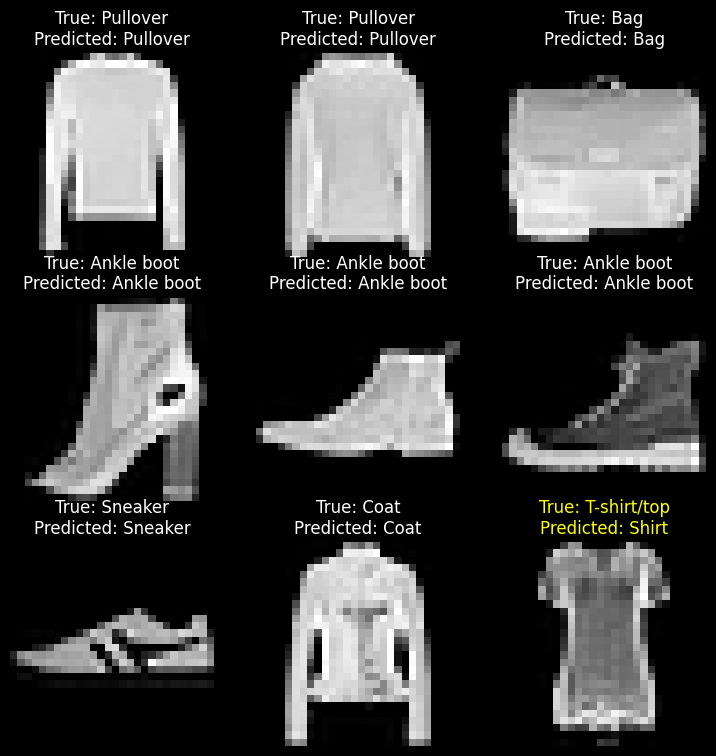

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
fig.set_facecolor(color="black")

for i in range(3*3):
  img = img_batch[i].reshape((28,28))
  img_label = class_names[label_batch[i].item()]
  predicted_label = class_names[batch_preds[i].item()]

  ax = axes.flatten()[i]
  ax.imshow(img, cmap="gray")
  ax.axis("off")

  ax_title = f"""True: {img_label}
Predicted: {predicted_label}"""
  if img_label == predicted_label:
    title_color = "white"
  else:
    title_color = "yellow"
  ax.set_title(label=ax_title, color=title_color)

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
y_true = test_ds.targets.numpy()
y_true.size

10000

In [ ]:
model3 = model3.to(device=device)
model3.eval()
with torch.inference_mode():
  y_preds_batch = []
  for x_batch, y_batch in test_dl:
        x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)
        y_logits_batch = model3(x_batch)
        y_preds_batch.append(torch.argmax(y_logits_batch, dim=1))

In [185]:
y_preds_tensor = torch.cat(tensors=y_preds_batch, dim=0)
y_preds_tensor

tensor([9, 2, 1,  ..., 8, 1, 5], device='cuda:0')

In [186]:
y_preds_tensor.shape

torch.Size([10000])

In [187]:
y_preds_all = y_preds_tensor.to(device="cpu").numpy()
y_preds_all

array([9, 2, 1, ..., 8, 1, 5])

In [188]:
print(classification_report(y_true=y_true, y_pred=y_preds_all, target_names=train_ds.classes))

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.83      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.92      0.76      0.83      1000
       Dress       0.89      0.91      0.90      1000
        Coat       0.81      0.87      0.84      1000
      Sandal       0.97      0.98      0.98      1000
       Shirt       0.66      0.77      0.71      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



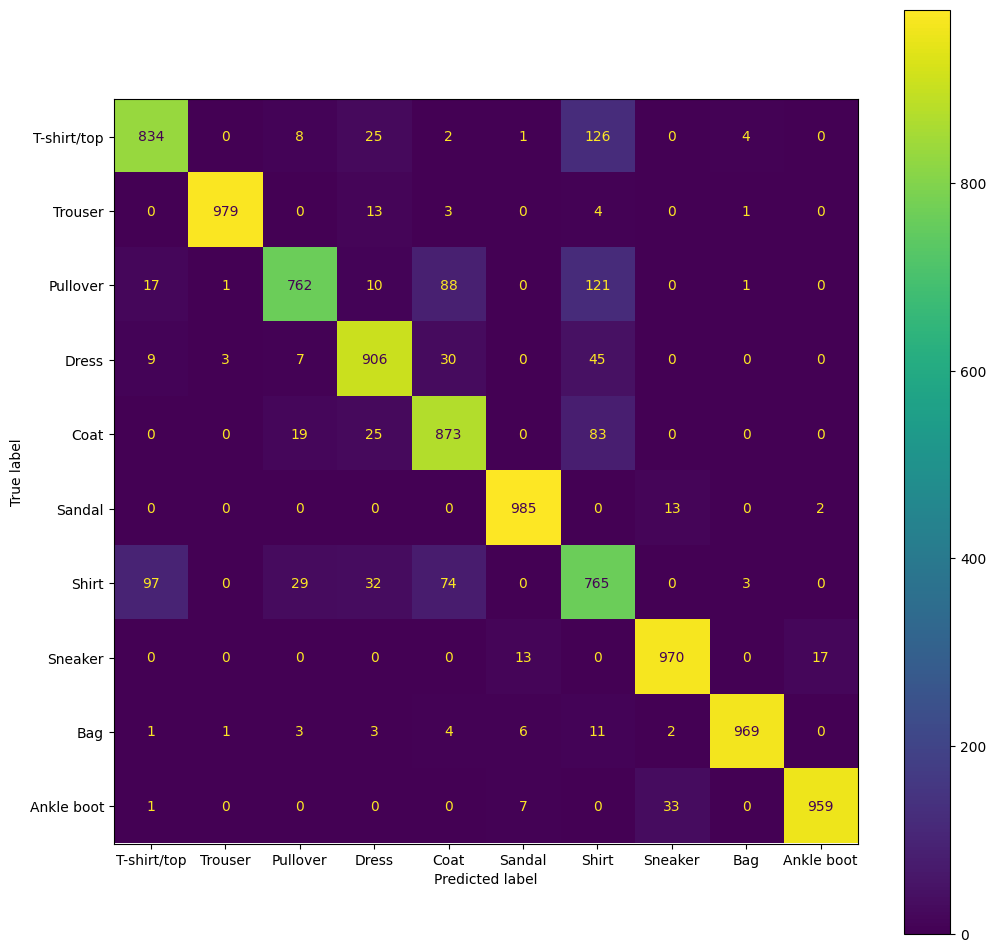

In [189]:
fig, ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_preds_all, display_labels=train_ds.classes, ax=ax)

Looks like the model has problems differentiating only between classes that would confuse even a human. Some of these shirts, coats and pullovers look the same to me too